In [1]:
import numpy as np
import os
import sys, os; sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')))
from utils.model_loader import get_model_fits
import numpy as np
import pandas as pd
import re
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt


/Users/augustarnstad/Documents/source_code/prior_paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.generate_data import load_linreg_dataset, generate_linreg_simple_data

rhos = [0.0, 0.5, 0.9]

# Map rho to the correct results directory
results_dir_map = {
    0.0: "results/regression/linreg/no_corr",
    0.5: "results/regression/linreg/medium_corr",
    0.9: "results/regression/linreg/high_corr",
}

model_names = [
    "Linreg Gaussian",
    "Linreg Regularized Horseshoe",
    "Linreg Dirichlet Horseshoe",
    "Linreg Dirichlet Student T",
    #"Linreg Beta Horseshoe",
    #"Linreg Beta Student T",
]

data_dir = "datasets/linreg"

# This will hold everything in an easy-to-handle structure
experiments = {}

for rho in rhos:
    # 1. Load data
    dataset_path = f"{data_dir}/linreg_data_rho_{rho}.npz"
    X_train, X_test, y_train, y_test, _, _, _ = load_linreg_dataset(
        path=dataset_path,
        test_fraction=0.2,
        seed=123,
    )

    # 2. True coefficients
    _, _, beta_true = generate_linreg_simple_data(rho=rho)

    # 3. Model fits
    results_dir_linreg = results_dir_map[rho]
    full_config_path = f"linreg_N200_p10_rho_{rho}"

    linreg_fit = get_model_fits(
        config=full_config_path,
        results_dir=results_dir_linreg,
        models=model_names,
        include_prior=False,
    )

    # 4. Store everything nicely under this rho
    experiments[rho] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "beta_true": beta_true,
        "results_dir": results_dir_linreg,
        "config": full_config_path,
        "fits": linreg_fit,
    }


16:05:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 8 divergent transitions (0.8%)
	Chain 3 had 8 divergent transitions (0.8%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
16:05:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 54 divergent transitions (5.4%)
	Chain 2 had 205 divergent transitions (20.5%)
	Chain 3 had 35 divergent transitions (3.5%)
	Chain 4 had 28 divergent transitions (2.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
16:05:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 23 divergent transitions (2.3%)
	Chain 2 had 36 divergent transitions (3.6%)
	Chain 3 had 22 divergent transitions (2.2%)
	Chain 4 had 58 divergent transitions (5.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further info

In [3]:
import numpy as np

rmse_results = {}

for rho, exp in experiments.items():
    X_train = exp["X_train"]
    X_test  = exp["X_test"]
    y_train = exp["y_train"]
    y_test  = exp["y_test"]
    fits    = exp["fits"]

    # Posterior samples
    beta_gauss = fits['Linreg Gaussian']['posterior'].stan_variable("beta")
    beta_RHS   = fits['Linreg Regularized Horseshoe']['posterior'].stan_variable("beta")
    beta_DHS   = fits['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("beta")
    beta_DST   = fits['Linreg Dirichlet Student T']['posterior'].stan_variable("beta")
    #beta_BHS   = fits['Linreg Beta Horseshoe']['posterior'].stan_variable("beta")
    #beta_BST   = fits['Linreg Beta Student T']['posterior'].stan_variable("beta")

    # GLS / OLS baseline
    beta_GLS = np.linalg.pinv(X_train.T @ X_train) @ (X_train.T @ y_train)

    # RMSEs based on posterior means
    rmse_gauss = np.sqrt(np.mean((y_test - X_test @ np.mean(beta_gauss, axis=0))**2))
    rmse_RHS   = np.sqrt(np.mean((y_test - X_test @ np.mean(beta_RHS,   axis=0))**2))
    rmse_DHS   = np.sqrt(np.mean((y_test - X_test @ np.mean(beta_DHS,   axis=0))**2))
    rmse_DST   = np.sqrt(np.mean((y_test - X_test @ np.mean(beta_DST,   axis=0))**2))
    #rmse_BHS   = np.sqrt(np.mean((y_test - X_test @ np.mean(beta_BHS,   axis=0))**2))
    #rmse_BST   = np.sqrt(np.mean((y_test - X_test @ np.mean(beta_BST,   axis=0))**2))
    rmse_GLS   = np.sqrt(np.mean((y_test - X_test @ beta_GLS)**2))

    rmse_results[rho] = {
        "Gaussian"       : rmse_gauss,
        "Regularized HS" : rmse_RHS,
        "Dirichlet HS"   : rmse_DHS,
        "Dirichlet ST"   : rmse_DST,
        #"Beta HS"        : rmse_BHS,
        #"Beta ST"        : rmse_BST,
        "GLS"            : rmse_GLS,
    }

# Nice printout
for rho in sorted(rmse_results.keys()):
    res = rmse_results[rho]
    print(f"\nRMSE summary for rho = {rho}")
    print("-" * 35)
    print(f"Gaussian        : {res['Gaussian']:.4f}")
    print(f"Regularized HS  : {res['Regularized HS']:.4f}")
    print(f"Dirichlet HS    : {res['Dirichlet HS']:.4f}")
    print(f"Dirichlet ST    : {res['Dirichlet ST']:.4f}")
    #print(f"Beta HS         : {res['Dirichlet HS']:.4f}")
    #print(f"Beta ST         : {res['Dirichlet ST']:.4f}")
    print(f"GLS             : {res['GLS']:.4f}")



RMSE summary for rho = 0.0
-----------------------------------
Gaussian        : 0.9872
Regularized HS  : 0.9458
Dirichlet HS    : 0.9420
Dirichlet ST    : 0.9420
GLS             : 0.9518

RMSE summary for rho = 0.5
-----------------------------------
Gaussian        : 1.0296
Regularized HS  : 0.9468
Dirichlet HS    : 0.9432
Dirichlet ST    : 0.9428
GLS             : 0.9518

RMSE summary for rho = 0.9
-----------------------------------
Gaussian        : 1.0791
Regularized HS  : 0.9537
Dirichlet HS    : 0.9574
Dirichlet ST    : 0.9566
GLS             : 0.9518


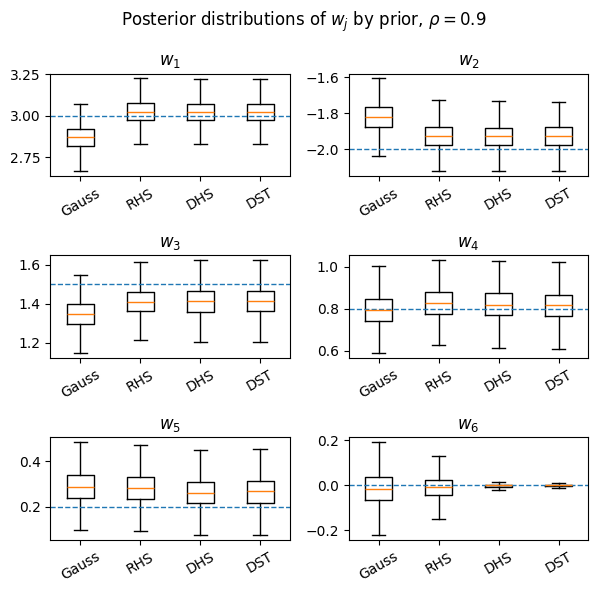

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- choose which rho to plot ---
rho_to_plot = 0.0   # change to 0.0 or 0.5 if you like

exp = experiments[rho_to_plot]
fits = exp["fits"]
beta_true = exp["beta_true"]

# Extract posterior draws for this rho
beta_gauss = fits['Linreg Gaussian']['posterior'].stan_variable("beta")
beta_RHS   = fits['Linreg Regularized Horseshoe']['posterior'].stan_variable("beta")
beta_DHS   = fits['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("beta")
beta_DST   = fits['Linreg Dirichlet Student T']['posterior'].stan_variable("beta")
#beta_BHS   = fits['Linreg Beta Horseshoe']['posterior'].stan_variable("beta")
#beta_BST   = fits['Linreg Beta Student T']['posterior'].stan_variable("beta")

S, P = beta_gauss.shape  # number of draws, number of coefficients

# Put all draws into one long DataFrame
def beta_to_long_df(beta_array, model_name):
    """
    beta_array: (S, P)
    returns DataFrame with columns: model, draw, coeff, beta
    """
    S, P = beta_array.shape
    df = pd.DataFrame(
        beta_array.reshape(S * P),
        columns=["beta"]
    )
    df["draw"] = np.repeat(np.arange(S), P)
    df["coeff"] = np.tile(np.arange(P), S)
    df["model"] = model_name
    return df

df_gauss = beta_to_long_df(beta_gauss, "Gaussian")
df_RHS   = beta_to_long_df(beta_RHS,   "Regularized Horseshoe")
df_DHS   = beta_to_long_df(beta_DHS,   "Dirichlet Horseshoe")
df_DST   = beta_to_long_df(beta_DST,   "Dirichlet Student T")
#df_BHS   = beta_to_long_df(beta_DHS,   "Beta Horseshoe")
#df_BST   = beta_to_long_df(beta_DST,   "Beta Student T")

beta_df = pd.concat([df_gauss, df_RHS, df_DHS, df_DST], ignore_index=True)
#beta_df = pd.concat([df_gauss, df_RHS, df_DHS, df_DST, df_BHS, df_BST], ignore_index=True)

# Attach true beta from experiments
beta_true_series = pd.Series(beta_true, index=np.arange(len(beta_true)))
beta_df["beta_true"] = beta_df["coeff"].map(beta_true_series)

# Boxplot per coefficient, grouped by model
coeffs_to_plot = 6
rows = 3
cols = int(np.ceil(coeffs_to_plot / rows))

fig, axes = plt.subplots(rows, cols, figsize=(6, 6), sharey=False)
axes = axes.flatten()

for j in range(coeffs_to_plot):
    ax = axes[j]
    df_j = beta_df[beta_df["coeff"] == j]

    # Boxplot of posterior for beta_j under each model
    data = [
        df_j[df_j["model"] == m]["beta"].values
        for m in ["Gaussian", "Regularized Horseshoe", "Dirichlet Horseshoe", "Dirichlet Student T"]#, "Beta Horseshoe", "Beta Student T"]
    ]
    ax.boxplot(data, showfliers=False)
    ax.set_xticks([1, 2, 3, 4])
    #ax.set_xticks([1, 2, 3, 4, 5, 6])
    ax.set_xticklabels(["Gauss", "RHS", "DHS", "DST"], rotation=30)
    #ax.set_xticklabels(["Gauss", "RHS", "DHS", "DST", "BHS", "BST"], rotation=30)
    ax.set_title(fr"$w_{{{j+1}}}$")

    # True beta as horizontal line
    ax.axhline(beta_true_series[j], linestyle="--", linewidth=1)

# Hide unused axes if any
for k in range(P, len(axes)):
    axes[k].axis("off")

fig.suptitle(fr"Posterior distributions of $w_j$ by prior, $\rho={rho}$", fontsize=12)
fig.tight_layout()
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- choose which rho to work with ---
rho_to_plot = 0.9  # or 0.0, 0.5

exp = experiments[rho_to_plot]
fits = exp["fits"]
X_train = exp["X_train"]
beta_true = exp["beta_true"]

# --- extract posterior draws for global/local scales and betas ---
beta_gauss = fits['Linreg Gaussian']['posterior'].stan_variable("beta")
sigma_gauss = fits['Linreg Gaussian']['posterior'].stan_variable("sigma")

beta_RHS = fits['Linreg Regularized Horseshoe']['posterior'].stan_variable("beta")
sigma_RHS = fits['Linreg Regularized Horseshoe']['posterior'].stan_variable("sigma")
tau_RHS   = fits['Linreg Regularized Horseshoe']['posterior'].stan_variable("tau")
lambda_RHS = fits['Linreg Regularized Horseshoe']['posterior'].stan_variable("lambda_tilde")

beta_DHS = fits['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("beta")
sigma_DHS = fits['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("sigma")
tau_DHS   = fits['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("tau")
lambda_DHS = fits['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("lambda_data")
xi_DHS     = fits['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("phi_data")

beta_DST = fits['Linreg Dirichlet Student T']['posterior'].stan_variable("beta")
sigma_DST = fits['Linreg Dirichlet Student T']['posterior'].stan_variable("sigma")
tau_DST   = fits['Linreg Dirichlet Student T']['posterior'].stan_variable("tau")
lambda_DST = fits['Linreg Dirichlet Student T']['posterior'].stan_variable("lambda_tilde")
xi_DST     = fits['Linreg Dirichlet Student T']['posterior'].stan_variable("phi_data")

# beta_BHS = fits['Linreg Beta Horseshoe']['posterior'].stan_variable("beta")
# sigma_BHS = fits['Linreg Beta Horseshoe']['posterior'].stan_variable("sigma")
# tau_BHS   = fits['Linreg Beta Horseshoe']['posterior'].stan_variable("tau")
# lambda_BHS = fits['Linreg Beta Horseshoe']['posterior'].stan_variable("lambda_data")
# xi_BHS     = fits['Linreg Beta Horseshoe']['posterior'].stan_variable("phi_data")

# beta_BST = fits['Linreg Beta Student T']['posterior'].stan_variable("beta")
# sigma_BST = fits['Linreg Beta Student T']['posterior'].stan_variable("sigma")
# tau_BST   = fits['Linreg Beta Student T']['posterior'].stan_variable("tau")
# lambda_BST = fits['Linreg Beta Student T']['posterior'].stan_variable("lambda_tilde")
# xi_BST     = fits['Linreg Beta Student T']['posterior'].stan_variable("phi_data")

# GLS baseline
beta_GLS = np.linalg.pinv(X_train.T @ X_train) @ (X_train.T @ exp["y_train"])

# infer dimensions
S, p = beta_RHS.shape       # number of posterior draws, number of covariates
N = X_train.shape[0]        # sample size used in the model

# --- compute shrinkage factors kappa and effective parameters m_eff ---
kappa_gauss = np.zeros((S, p))
kappa_RHS = np.zeros((S, p))
kappa_DHS = np.zeros((S, p))
kappa_DST = np.zeros((S, p))
# kappa_BHS = np.zeros((S, p))
# kappa_BST = np.zeros((S, p))

meff_gauss = np.zeros(S)
meff_RHS = np.zeros(S)
meff_DHS = np.zeros(S)
meff_DST = np.zeros(S)
# meff_BHS = np.zeros(S)
# meff_BST = np.zeros(S)

for i in range(S):
     # RHS: kappa_j = 1 / (1 + N * sigma^-2 * tau^2 * lambda_j)
    kappa_gauss[i] = 1.0 / (1.0 + N * sigma_gauss[i]**(-2))
    
    # RHS: kappa_j = 1 / (1 + N * sigma^-2 * tau^2 * lambda_j)
    kappa_RHS[i] = 1.0 / (1.0 + N * sigma_RHS[i]**(-2) * tau_RHS[i]**2 * lambda_RHS[i])

    # DHS: kappa_j = 1 / (1 + N * sigma^-2 * tau^2 * lambda_j * xi_j)
    kappa_DHS[i] = 1.0 / (1.0 + N * sigma_DHS[i]**(-2) * tau_DHS[i]**2 * lambda_DHS[i] * xi_DHS[i])

    # DST: same structure, but with DST parameters (note: tau_DST, not tau_DHS)
    kappa_DST[i] = 1.0 / (1.0 + N * sigma_DST[i]**(-2) * tau_DST[i]**2 * lambda_DST[i] * xi_DST[i])
    
#     # BHS: kappa_j = 1 / (1 + N * sigma^-2 * tau^2 * lambda_j * xi_j)
#     kappa_BHS[i] = 1.0 / (1.0 + N * sigma_BHS[i]**(-2) * tau_BHS[i]**2 * lambda_BHS[i] * xi_BHS[i])

#     # BST: same structure, but with DST parameters (note: tau_DST, not tau_DHS)
#     kappa_BST[i] = 1.0 / (1.0 + N * sigma_BST[i]**(-2) * tau_BST[i]**2 * lambda_BST[i] * xi_BST[i])

    meff_gauss[i] = np.sum(1.0 - kappa_gauss[i])
    meff_RHS[i] = np.sum(1.0 - kappa_RHS[i])
    meff_DHS[i] = np.sum(1.0 - kappa_DHS[i])
    meff_DST[i] = np.sum(1.0 - kappa_DST[i])
#     meff_BHS[i] = np.sum(1.0 - kappa_BHS[i])
#     meff_BST[i] = np.sum(1.0 - kappa_BST[i])

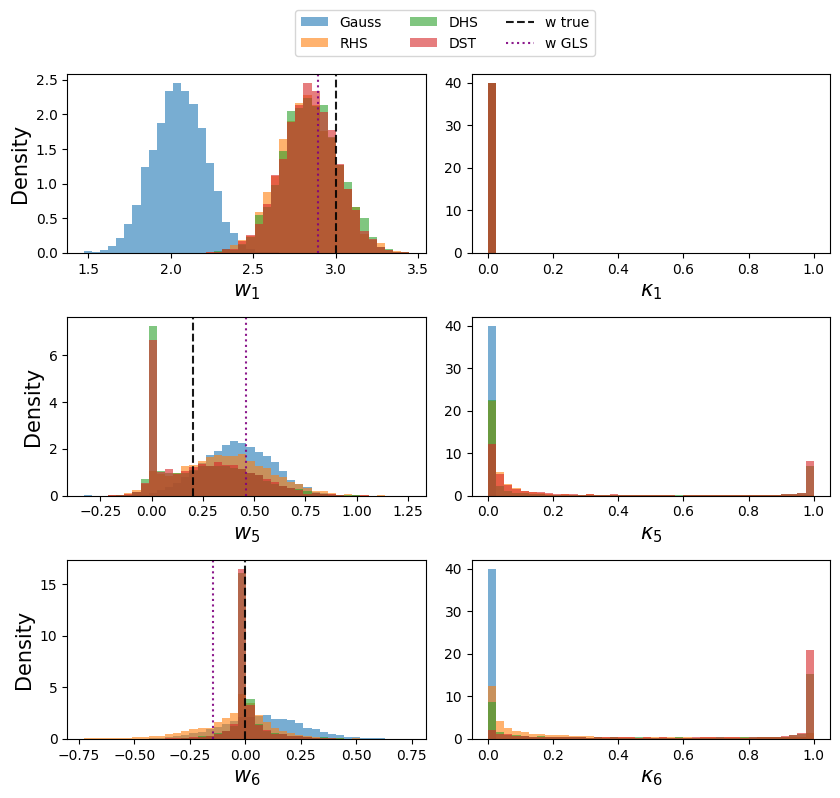

In [10]:
# ------------------------------------------------------
# 1) Plot kappa and beta posteriors for selected coeffs
# ------------------------------------------------------

# Indices of coefficients to visualize
idxs = [0, 4, 5]

# If you want to hard-code "true" betas, use this:
beta_true_vals = {0: 3, 4: 0.2, 5: 0.0}
titles = {
    0: r"$\beta_1$", #1: r"$\beta_2$", 
    #2: r"$\beta_3$", 3: r"$\beta_4$", 
    4: r"$\beta_5$", 5: r"$\beta_6$"
}

def common_bins(*arrays, bins=40, range=None):
    """Compute common histogram bin edges for multiple arrays."""
    data = np.concatenate([a.ravel() for a in arrays])
    return np.histogram_bin_edges(data, bins=bins, range=range)

fig, axes = plt.subplots(len(idxs), 2, figsize=(10, 8), sharex=False, sharey=False)
# fig.suptitle(
#     fr"Posterior samples of $\kappa$ and $w$, $\rho={rho_to_plot}$",
#     fontsize=12,
#     x=0.4,              # explicitly center horizontally
#     ha='center'         # horizontal alignment
# )

for row, j in enumerate(idxs):
    ax_kappa = axes[row, 1]
    ax_beta  = axes[row, 0]

    # --- Kappa posterior ---
    bins_kappa = common_bins(kappa_gauss[:, j], kappa_RHS[:, j], kappa_DHS[:, j], kappa_DST[:, j],
                             bins=40, range=(0, 1.0))
    ax_kappa.hist(kappa_gauss[:, j], bins=bins_kappa, alpha=0.6, label="Gauss", density=True, color = "C0")
    ax_kappa.hist(kappa_RHS[:, j], bins=bins_kappa, alpha=0.6, label="RHS", density=True, color = "C1")
    ax_kappa.hist(kappa_DHS[:, j], bins=bins_kappa, alpha=0.6, label="DHS", density=True, color = "C2")
    ax_kappa.hist(kappa_DST[:, j], bins=bins_kappa, alpha=0.6, label="DST", density=True, color = "C3")
    #ax_kappa.hist(kappa_BHS[:, j], bins=bins_kappa, alpha=0.6, label="BHS", density=True, color = "C4")
    #ax_kappa.hist(kappa_BST[:, j], bins=bins_kappa, alpha=0.6, label="BST", density=True, color = "C5")
    ax_kappa.set_xlabel(fr"$\kappa_{j+1}$", fontsize=15)
    #if row == 0:
    #ax_kappa.set_ylabel("Density")
    #ax_kappa.set_title(f"Kappa, {titles[j]}")

    # --- Beta posterior ---
    bins_beta = common_bins(beta_gauss[:, j], beta_RHS[:, j], beta_DHS[:, j], beta_DST[:, j], bins=40)
    ax_beta.hist(beta_gauss[:, j], bins=bins_beta, alpha=0.6, label="Gauss", density=True)
    ax_beta.hist(beta_RHS[:, j], bins=bins_beta, alpha=0.6, label="RHS", density=True, color = "C1")
    ax_beta.hist(beta_DHS[:, j], bins=bins_beta, alpha=0.6, label="DHS", density=True, color = "C2")
    ax_beta.hist(beta_DST[:, j], bins=bins_beta, alpha=0.6, label="DST", density=True, color = "C3")
    #ax_beta.hist(beta_BHS[:, j], bins=bins_beta, alpha=0.6, label="BHS", density=True, color = "C4")
    #ax_beta.hist(beta_BST[:, j], bins=bins_beta, alpha=0.6, label="BST", density=True, color = "C5")
    # Add true and GLS lines
    ax_beta.axvline(beta_true_vals[j], alpha=0.9, label="w true", color="black", linestyle="--")
    ax_beta.axvline(beta_GLS[j], alpha=0.9, label="w GLS", color="purple", linestyle=":")
    ax_beta.set_xlabel(fr"$w_{j+1}$", fontsize=15)
    ax_beta.set_ylabel("Density", fontsize=15)
    #ax_beta.set_title(f"Beta, {titles[j]}")

# One legend for beta panels
handles, labels = axes[0, 0].get_legend_handles_labels()

fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.45, 1))
fig.tight_layout(rect=[0, 0, 0.85, 0.93])
fig.savefig("figures_for_use_in_paper/w_vs_kappa.pdf", bbox_inches="tight")
plt.show()


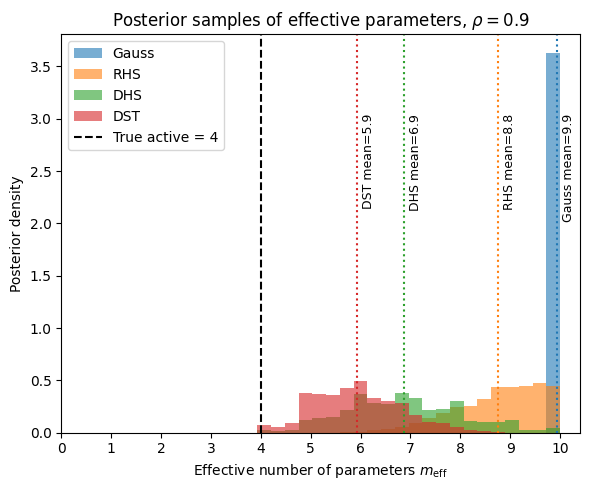

In [7]:

# ------------------------------------------------------
# 2) Plot posterior distribution of effective parameters
# ------------------------------------------------------

P = p
bins = np.linspace(2, 10, 30)#np.arange(0, P + 2) - 0.1  # bin edges at integers

plt.figure(figsize=(6, 5))

# Use plt.hist to keep dependencies minimal
plt.hist(meff_gauss, bins=bins, density=True, alpha=0.6, label="Gauss", histtype="stepfilled")
plt.hist(meff_RHS, bins=bins, density=True, alpha=0.6, label="RHS", histtype="stepfilled")
plt.hist(meff_DHS, bins=bins, density=True, alpha=0.6, label="DHS", histtype="stepfilled")
plt.hist(meff_DST, bins=bins, density=True, alpha=0.6, label="DST", histtype="stepfilled")
# plt.hist(meff_BHS, bins=bins, density=True, alpha=0.6, label="BHS", histtype="stepfilled")
# plt.hist(meff_BST, bins=bins, density=True, alpha=0.6, label="BST", histtype="stepfilled")

# vertical line at true number of active coefficients
true_active = 4  # adjust if needed
plt.axvline(true_active, color="black", linestyle="--", linewidth=1.5,
            label=f"True active = {true_active}")

# add posterior means as vertical lines + text
ymax = plt.ylim()[1]
for Meff, label, color in [
    (meff_gauss, "Gauss", "C0"),
    (meff_RHS, "RHS", "C1"),
    (meff_DHS, "DHS", "C2"),
    (meff_DST, "DST", "C3"),
    # (meff_BHS, "BHS", "C4"),
    # (meff_BST, "BST", "C5"),
]:
    mean_val = np.mean(Meff)
    plt.axvline(mean_val, color=color, linestyle=":", linewidth=1.5)
    plt.text(mean_val + 0.1, ymax * 0.8,
             f"{label} mean={mean_val:.1f}",
             color="black", fontsize=9, rotation=90, va="top")

plt.xticks(range(0, P + 1))
plt.xlabel(r"Effective number of parameters $m_{\mathrm{eff}}$")
plt.ylabel("Posterior density")
plt.title(fr"Posterior samples of effective parameters, $\rho={rho_to_plot}$")
plt.legend()
plt.tight_layout()
plt.show()


## FIXING PLOTS

In [8]:
import numpy as np
import pandas as pd

model_names = [
    "Linreg Gaussian",
    "Linreg Regularized Horseshoe",
    "Linreg Dirichlet Horseshoe",
    "Linreg Dirichlet Student T",
    # "Linreg Beta Horseshoe",
    # "Linreg Beta Student T",
]

def beta_to_long_df(beta_array, model_name, rho, beta_true):
    """
    beta_array: (S, P)
    returns DataFrame with columns: rho, model, draw, coeff, beta, beta_true
    """
    S, P = beta_array.shape
    df = pd.DataFrame(
        beta_array.reshape(S * P),
        columns=["beta"]
    )
    df["draw"] = np.repeat(np.arange(S), P)
    df["coeff"] = np.tile(np.arange(P), S)
    df["model"] = model_name
    df["rho"] = rho
    # attach true beta per coefficient
    beta_true_series = pd.Series(beta_true, index=np.arange(len(beta_true)))
    df["beta_true"] = df["coeff"].map(beta_true_series)
    return df

all_dfs = []

for rho, exp in experiments.items():
    fits = exp["fits"]
    beta_true = exp["beta_true"]

    beta_gauss = fits['Linreg Gaussian']['posterior'].stan_variable("beta")
    beta_RHS   = fits['Linreg Regularized Horseshoe']['posterior'].stan_variable("beta")
    beta_DHS   = fits['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("beta")
    beta_DST   = fits['Linreg Dirichlet Student T']['posterior'].stan_variable("beta")
    # beta_BHS   = fits['Linreg Beta Horseshoe']['posterior'].stan_variable("beta")
    # beta_BST   = fits['Linreg Beta Student T']['posterior'].stan_variable("beta")

    all_dfs.append(beta_to_long_df(beta_gauss, "Gauss",             rho, beta_true))
    all_dfs.append(beta_to_long_df(beta_RHS,   "RHS",       rho, beta_true))
    all_dfs.append(beta_to_long_df(beta_DHS,   "DHS",         rho, beta_true))
    all_dfs.append(beta_to_long_df(beta_DST,   "DST",  rho, beta_true))
    # all_dfs.append(beta_to_long_df(beta_BHS,   "BHS",         rho, beta_true))
    # all_dfs.append(beta_to_long_df(beta_BST,   "BST",  rho, beta_true))

beta_all = pd.concat(all_dfs, ignore_index=True)


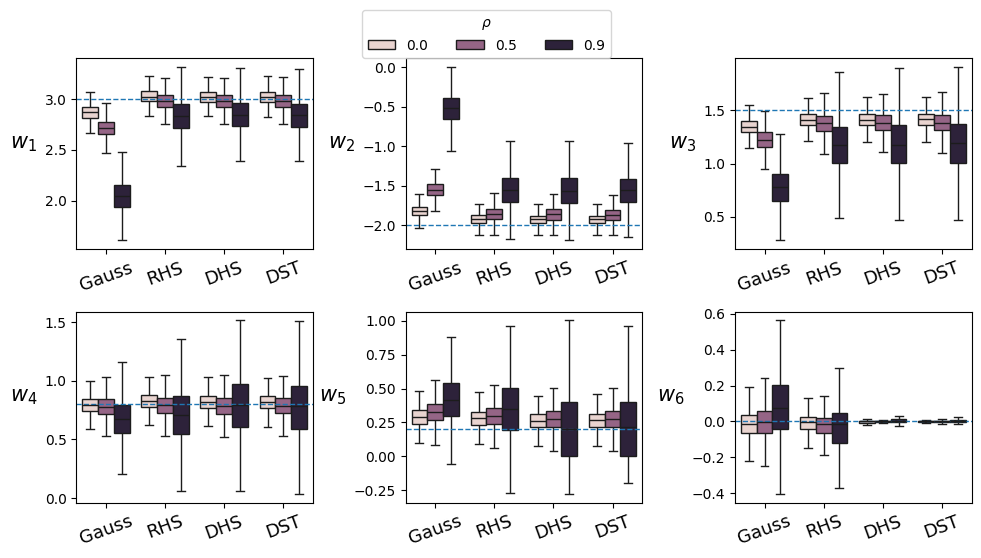

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# coefficients to visualize
coeffs_to_plot = [0, 1, 2, 3, 4, 5]   # β1,…,β6
rows, cols = 2, 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 8), sharey=False)
axes = axes.flatten()

for idx, j in enumerate(coeffs_to_plot):
    ax = axes[idx]
    df_j = beta_all[beta_all["coeff"] == j].copy()

    # nice ordering for models and rho
    df_j["model"] = pd.Categorical(
        df_j["model"],
        categories=["Gauss", "RHS", "DHS", "DST"], #, "BHS", "BST"],
        ordered=True,
    )
    df_j["rho"] = df_j["rho"].astype(float)

    sns.boxplot(
        data=df_j,
        x="model",
        y="beta",
        hue="rho",
        ax=ax,
        showfliers=False,
    )

    # true beta line
    beta_true_j = df_j["beta_true"].iloc[0]
    ax.axhline(beta_true_j, linestyle="--", linewidth=1)

    ax.set_xlabel("")
    ax.set_ylabel(fr"$w_{{{j+1}}}$", fontsize=15, rotation=0, labelpad=15)
    #ax.set_title(fr"$w_{{{j+1}}}$", fontsize=11)
    ax.tick_params(axis="x", rotation=20, labelsize=13)

# remove extra axes if any
for k in range(len(coeffs_to_plot), len(axes)):
    axes[k].axis("off")

# one legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title=r"$\rho$", loc="upper center", bbox_to_anchor=(0.5, 1.0), ncol=3)
for ax in axes:
    ax.get_legend().remove()

#fig.suptitle(r"Posterior distributions of $w_j$ by prior and correlation $\rho$", fontsize=13)
fig.tight_layout(rect=[0, 0.3, 1, 0.95])
fig.savefig("figures_for_use_in_paper/w_distribution.pdf", bbox_inches="tight")
plt.show()


## Exploartory

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, dirichlet, norm
import seaborn as sns

# --- scale parameter ---
p=10
alpha = 0.1
alpha_vec = [alpha, alpha, alpha, alpha, alpha, alpha, alpha, alpha, alpha, alpha]
samples_A = dirichlet.rvs(alpha = alpha_vec, size=10000)
samples_B = beta.rvs(a = alpha, b = (p-1)*alpha, size=(10000, 10))

# --- 2-dim joint contour KDE for Dirichlet vs Beta ---
plt.figure(figsize=(12, 10))

sns.kdeplot(
    x=samples_A[:, 0],
    y=samples_A[:, 1],
    levels=5,
    cmap="Reds",
    linewidths=2.0,
    label="Dirichlet"
)
sns.kdeplot(
    x=samples_B[:, 0],
    y=samples_B[:, 1],
    levels=5,
    cmap="Blues",
    linewidths=2.0,
    label="Beta"
)
plt.title("Joint density of (x₁, x₂): Dirichlet vs independent Beta")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, dirichlet, norm

# --- scale parameter ---
p = 10
alpha = 0.1
alpha_vec = [alpha] * p

# 1000 draws of 10-dim Dirichlet and independent Betas
samples_A = dirichlet.rvs(alpha=alpha_vec, size=1000)               # shape (1000, 10)
samples_B = beta.rvs(a=alpha, b=(p-1)*alpha, size=(1000, p))       # shape (1000, 10)

# Convert "variance" factors into std deviations for the normals
std_A = np.sqrt(samples_A)   # same shape (1000, 10)
std_B = np.sqrt(samples_B)   # same shape (1000, 10)

# Draw normals with variance given by samples_A / samples_B
# np.random.normal broadcasts over the array of stds
norm_A = np.random.normal(loc=0.0, scale=std_A)   # shape (1000, 10)
norm_B = np.random.normal(loc=0.0, scale=std_B)   # shape (1000, 10)

print(norm_A.shape, norm_B.shape)
# -> (1000, 10) (1000, 10)


In [ ]:
# Correlation between coordinates for the *scales* themselves
corr_xi_dir = np.corrcoef(samples_A, rowvar=False)   # 10x10
corr_xi_beta = np.corrcoef(samples_B, rowvar=False)  # 10x10

# Correlation between coordinates for the *normals*
corr_norm_dir = np.corrcoef(norm_A, rowvar=False)    # 10x10
corr_norm_beta = np.corrcoef(norm_B, rowvar=False)   # 10x10

print("Mean off-diagonal corr (Dirichlet scales):", 
      (corr_xi_dir - np.eye(p))[np.triu_indices(p, 1)].mean())
print("Mean off-diagonal corr (Beta scales):", 
      (corr_xi_beta - np.eye(p))[np.triu_indices(p, 1)].mean())

print("Mean off-diagonal corr (Dirichlet normals):", 
      (corr_norm_dir - np.eye(p))[np.triu_indices(p, 1)].mean())
print("Mean off-diagonal corr (Beta normals):", 
      (corr_norm_beta - np.eye(p))[np.triu_indices(p, 1)].mean())


In [ ]:
# --- helper to extract average off-diagonal correlation ---
def offdiag_mean_corr(M):
    return (M - np.eye(M.shape[0]))[np.triu_indices(M.shape[0], 1)].mean()

# --- investigate dependence in magnitudes and higher moments ---

# 1. Correlation of |x|, x^2, x^3 for normals from Dirichlet scales
corr_abs_A = np.corrcoef(np.abs(norm_A), rowvar=False)
corr_sq_A  = np.corrcoef(norm_A**2,      rowvar=False)
corr_cu_A  = np.corrcoef(norm_A**4,      rowvar=False)

# 2. Same for normals from Beta scales (should be ~0)
corr_abs_B = np.corrcoef(np.abs(norm_B), rowvar=False)
corr_sq_B  = np.corrcoef(norm_B**2,      rowvar=False)
corr_cu_B  = np.corrcoef(norm_B**4,      rowvar=False)

print("Dirichlet scales → normals:")
print("  mean corr(|x|):", offdiag_mean_corr(corr_abs_A))
print("  mean corr(x^2):", offdiag_mean_corr(corr_sq_A))
print("  mean corr(x^4):", offdiag_mean_corr(corr_cu_A))

print("\nIndependent Beta scales → normals:")
print("  mean corr(|x|):", offdiag_mean_corr(corr_abs_B))
print("  mean corr(x^2):", offdiag_mean_corr(corr_sq_B))
print("  mean corr(x^4):", offdiag_mean_corr(corr_cu_B))


## OLD CODE

In [14]:
from utils.generate_data import load_linreg_dataset, generate_linreg_simple_data
rho=0.9
X_train, X_test, y_train, y_test, _, _, _ = load_linreg_dataset(
    path=f"datasets/linreg/linreg_data_rho_{rho}.npz",
    test_fraction=0.2,
    seed=123,
)

_, _, beta_true = generate_linreg_simple_data(rho=rho)

In [ ]:
data_dir = f"datasets/linreg"
results_dir_linreg = "results/regression/linreg/high_corr"
#results_dir_linreg_prior = "results/regression/linreg/prior"
#model_names_relu = ["Dirichlet Student T"]
model_names = ["Linreg Gaussian", "Linreg Regularized Horseshoe", "Linreg Dirichlet Horseshoe", "Linreg Dirichlet Student T"]


full_config_path = f"linreg_N200_p10_rho_{rho}"
linreg_fit = get_model_fits(
    config=full_config_path,
    results_dir=results_dir_linreg,
    models=model_names,
    include_prior=False,
)


In [ ]:
beta_gauss = linreg_fit['Linreg Gaussian']['posterior'].stan_variable("beta")
beta_RHS = linreg_fit['Linreg Regularized Horseshoe']['posterior'].stan_variable("beta")
beta_DHS = linreg_fit['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("beta")
beta_DST = linreg_fit['Linreg Dirichlet Student T']['posterior'].stan_variable("beta")
beta_GLS = np.linalg.pinv((X_train.T@X_train))@X_train.T@y_train

posterior_mean_rmse_gauss = np.sqrt(np.mean((y_test - X_test@np.mean(beta_gauss, axis=0))**2))
posterior_mean_rmse_RHS = np.sqrt(np.mean((y_test - X_test@np.mean(beta_RHS, axis=0))**2))
posterior_mean_rmse_DHS = np.sqrt(np.mean((y_test - X_test@np.mean(beta_DHS, axis=0))**2))
posterior_mean_rmse_DST = np.sqrt(np.mean((y_test - X_test@np.mean(beta_DST, axis=0))**2))
rmse_GLS = np.sqrt(np.mean((y_test - X_test@beta_GLS)**2))

print("Gauss:", posterior_mean_rmse_gauss,
      "\nRHS:", posterior_mean_rmse_RHS, 
      "\nDHS", posterior_mean_rmse_DHS, 
      "\nDST", posterior_mean_rmse_DST,
      "\nGLS:", rmse_GLS)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Make sure y_train is 1D shape (N,)
y_vec = np.asarray(y_test).reshape(-1)
N = X_train.shape[0]

def rmse_per_sample(beta_samples, X, y):
    """
    beta_samples: (S, P)
    X: (N, P)
    y: (N,)
    Returns: array (S,) of RMSEs, one per posterior draw
    """
    # Predictions for all samples at once: (N, S)
    preds = X @ beta_samples.T
    # Broadcast y to (N, S)
    errors = preds - y[:, None]
    mse = np.mean(errors**2, axis=0)
    rmse = np.sqrt(mse)
    return rmse

rmse_gauss_samps = rmse_per_sample(beta_gauss, X_test, y_vec)
rmse_RHS_samps   = rmse_per_sample(beta_RHS,   X_test, y_vec)
rmse_DHS_samps   = rmse_per_sample(beta_DHS,   X_test, y_vec)
rmse_DST_samps   = rmse_per_sample(beta_DST,   X_test, y_vec)


# -------- Density plot of RMSEs --------
plt.figure(figsize=(8, 5))

def plot_rmse_kde(rmse_samples, label, posterior_mean_rmse, color):
    kde = gaussian_kde(rmse_samples)
    xs = np.linspace(np.percentile(rmse_samples, 1),
                     np.percentile(rmse_samples, 99), 200)
    plt.plot(xs, kde(xs), label=label, color=color)
    plt.axvline(x=posterior_mean_rmse, color=color, linestyle="--")
    plt.axvline(x=np.mean(rmse_samples), color=color, linestyle="-")

plot_rmse_kde(rmse_gauss_samps, "Gaussian", posterior_mean_rmse_gauss, "C0")
plot_rmse_kde(rmse_RHS_samps,   "RHS", posterior_mean_rmse_RHS, "C1")
plot_rmse_kde(rmse_DHS_samps,   "DHS", posterior_mean_rmse_DHS, "C2")
plot_rmse_kde(rmse_DST_samps,   "DST", posterior_mean_rmse_DST, "C3")

plt.axvline(x=rmse_GLS, label="GLS", color="black", linestyle="dotted")
plt.xlabel("RMSE on training data")
plt.ylabel("Posterior density")
plt.title("Posterior distribution of RMSE per model")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

S, P = beta_gauss.shape  # number of draws, number of coefficients
# Put all draws into one long DataFrame
def beta_to_long_df(beta_array, model_name):
    """
    beta_array: (S, P)
    returns DataFrame with columns: model, draw, coeff, beta
    """
    S, P = beta_array.shape
    df = pd.DataFrame(
        beta_array.reshape(S * P),
        columns=["beta"]
    )
    df["draw"] = np.repeat(np.arange(S), P)
    df["coeff"] = np.tile(np.arange(P), S)
    df["model"] = model_name
    return df

df_gauss = beta_to_long_df(beta_gauss, "Gaussian")
df_RHS   = beta_to_long_df(beta_RHS,   "Regularized Horseshoe")
df_DHS   = beta_to_long_df(beta_DHS,   "Dirichlet Horseshoe")
df_DST   = beta_to_long_df(beta_DST,   "Dirichlet Student-t")

beta_df = pd.concat([df_gauss, df_RHS, df_DHS, df_DST], ignore_index=True)

# Optional: attach true beta if you have it loaded from the dataset
if "beta_true" in globals():
    beta_true_series = pd.Series(beta_true, index=np.arange(len(beta_true)))
    beta_df["beta_true"] = beta_df["coeff"].map(beta_true_series)
else:
    beta_true_series = None


In [ ]:
# Boxplot per coefficient, grouped by model
fig, axes = plt.subplots(5, int(np.ceil(P / 5)), figsize=(16, 16), sharey=False)
axes = axes.flatten()

for j in range(P):
    ax = axes[j]
    df_j = beta_df[beta_df["coeff"] == j]
    # Make a simple boxplot of posterior for beta_j under each model
    data = [df_j[df_j["model"] == m]["beta"].values
            for m in ["Gaussian", "Regularized Horseshoe", "Dirichlet Horseshoe", "Dirichlet Student-t"]]
    ax.boxplot(data, showfliers=False)
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(["Gauss", "RHS", "DHS", "DST"], rotation=30)
    ax.set_title(f"β_{j+1}")

    # If true beta is known, add a horizontal line
    if beta_true_series is not None:
        ax.axhline(beta_true_series[j], linestyle="--", linewidth=1)

# Hide unused axes if P is odd
for k in range(P, len(axes)):
    axes[k].axis("off")

fig.suptitle("Posterior distributions of β_j by prior (boxplots)", fontsize=14)
fig.tight_layout()
plt.show()


In [ ]:
from scipy.stats import gaussian_kde

def plot_beta_kde_for_coeff(j, ax):
    """
    j: coefficient index
    ax: matplotlib axis
    """
    df_j = beta_df[beta_df["coeff"] == j]

    for model_name, label in [
        ("Gaussian", "Gauss"),
        ("Regularized Horseshoe", "RHS"),
        ("Dirichlet Horseshoe", "DHS"),
        ("Dirichlet Student-t", "DST"),
    ]:
        samples = df_j[df_j["model"] == model_name]["beta"].values
        kde = gaussian_kde(samples)
        xs = np.linspace(np.percentile(samples, 1),
                         np.percentile(samples, 99), 200)
        ax.plot(xs, kde(xs), label=label, alpha=0.8)

    if beta_true_series is not None:
        ax.axvline(beta_true_series[j], linestyle="--", linewidth=1)

    ax.set_title(f"β_{j+1}")
    ax.legend(fontsize=8)

# Choose which coefficients to inspect more closely
coeffs_to_plot = [0, 1, 2, 3, 4, 5]  # likely non-zero in your synthetic setup
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, j in enumerate(coeffs_to_plot):
    plot_beta_kde_for_coeff(j, axes[idx])

fig.suptitle("Marginal posterior densities of selected β_j", fontsize=14)
fig.tight_layout()
plt.show()


In [21]:
# beta_gauss = linreg_fit['Linreg Gaussian']['posterior'].stan_variable("beta")
sigma_RHS = linreg_fit['Linreg Regularized Horseshoe']['posterior'].stan_variable("sigma")
tau_RHS = linreg_fit['Linreg Regularized Horseshoe']['posterior'].stan_variable("tau")
lambda_RHS = linreg_fit['Linreg Regularized Horseshoe']['posterior'].stan_variable("lambda_tilde")

sigma_DHS = linreg_fit['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("sigma")
tau_DHS = linreg_fit['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("tau")
lambda_DHS = linreg_fit['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("lambda_data")
xi_DHS = linreg_fit['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("phi_data")

sigma_DST = linreg_fit['Linreg Dirichlet Student T']['posterior'].stan_variable("sigma")
tau_DST = linreg_fit['Linreg Dirichlet Student T']['posterior'].stan_variable("tau")
lambda_DST = linreg_fit['Linreg Dirichlet Student T']['posterior'].stan_variable("lambda_tilde")
xi_DST = linreg_fit['Linreg Dirichlet Student T']['posterior'].stan_variable("phi_data")


In [22]:
S, N, p = 4000, 200, 10

kappa_RHS = np.zeros((S, p))
kappa_DHS = np.zeros((S, p))
kappa_DST = np.zeros((S, p))

meff_RHS = np.zeros((S))
meff_DHS = np.zeros((S))
meff_DST = np.zeros((S))

for i in range(S):
    kappa_RHS[i] = 1/(1+(N*sigma_RHS[i]**(-2)*tau_RHS[i]**2*lambda_RHS[i]))
    kappa_DHS[i] = 1/(1+(N*sigma_DHS[i]**(-2)*tau_DHS[i]**2*lambda_DHS[i]*xi_DHS[i]))
    kappa_DST[i] = 1/(1+(N*sigma_DST[i]**(-2)*tau_DST[i]**2*lambda_DST[i]*xi_DST[i]))
    
    meff_RHS[i] = np.sum(1 - kappa_RHS[i])
    meff_DHS[i] = np.sum(1 - kappa_DHS[i])
    meff_DST[i] = np.sum(1 - kappa_DST[i])



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

S, p = 4000, 10  # as before

# Indices of coefficients to visualize
idxs = [0, 1, 2, 3, 4, 5]
beta_true_vals = {0: 3, 1: -2, 2: 1.5, 3:0.8, 4:0.2, 5:0.0}   # your ground truth
titles = {0: r"$\beta_1$", 1: r"$\beta_2$", 2: r"$\beta_3$", 3: r"$\beta_4$", 4: r"$\beta_5$", 5: r"$\beta_6$"}  # optional niceness

def common_bins(*arrays, bins=40, range=None):
    """Compute common histogram bin edges for multiple arrays."""
    data = np.concatenate([a.ravel() for a in arrays])
    return np.histogram_bin_edges(data, bins=bins, range=range)

fig, axes = plt.subplots(len(idxs), 2, figsize=(8, 12), sharex=False, sharey="row")
fig.suptitle("Posterior distributions of shrinkage ($\\kappa$) and coefficients ($\\beta$)")

for row, j in enumerate(idxs):
    ax_kappa = axes[row, 0]
    ax_beta  = axes[row, 1]

    # --- Kappa posterior ---
    bins_kappa = common_bins(kappa_RHS[:, j], kappa_DHS[:, j], kappa_DST[:, j], bins=40, range=(0, 1.0))
    ax_kappa.hist(kappa_RHS[:, j], bins=bins_kappa, alpha=0.6, label="RHS", density=True)
    ax_kappa.hist(kappa_DHS[:, j], bins=bins_kappa, alpha=0.6, label="DHS", density=True)
    ax_kappa.hist(kappa_DST[:, j], bins=bins_kappa, alpha=0.6, label="DST", density=True)
    ax_kappa.set_xlabel(r"$\kappa$")
    ax_kappa.set_ylabel("Density" if row == 0 else "")
    ax_kappa.set_title(f"Kappa, {titles[j]}")

    # --- Beta posterior ---
    bins_beta = common_bins(beta_RHS[:, j], beta_DHS[:, j], bins=40)  # auto range
    ax_beta.hist(beta_RHS[:, j], bins=bins_beta, alpha=0.6, label="RHS", density=True)
    ax_beta.hist(beta_DHS[:, j], bins=bins_beta, alpha=0.6, label="DHS", density=True)
    ax_beta.hist(beta_DST[:, j], bins=bins_beta, alpha=0.6, label="DHS", density=True)

    # Add true and GLS lines
    ax_beta.axvline(beta_true_vals[j], alpha=0.9, label="Beta_true", color="green", linestyle="--")
    ax_beta.axvline(beta_GLS[j], alpha=0.9, label="Beta_GLS", color="red", linestyle=":")
    ax_beta.set_xlabel(r"$\beta$")
    ax_beta.set_title(f"Beta, {titles[j]}")

# Put a single legend outside
handles, labels = axes[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

P = 10  # number of covariates
bins = np.arange(0, P + 2) - 0.5  # bin edges at integers

plt.figure(figsize=(5, 5))

sns.histplot(meff_RHS, bins=bins, stat="density", element="step",
             fill=True, label="RHS")
sns.histplot(meff_DHS, bins=bins, stat="density", element="step",
             fill=True, label="DHS")
sns.histplot(meff_DST, bins=bins, stat="density", element="step",
             fill=True, label="DST")

# vertical line at true number of active coefficients
plt.axvline(4, color="black", linestyle="--", linewidth=1.5,
            label="True active = 4")

# add posterior means as markers
for Meff, label, color in [
    (meff_RHS, "RHS", "C0"),
    (meff_DHS, "DHS", "C1"),
    (meff_DST, "DST", "C2"),
]:
    mean_val = np.mean(Meff)
    plt.axvline(mean_val, color=color, linestyle=":",
                linewidth=1.5)
    plt.text(mean_val + 0.1, plt.ylim()[1]*0.8,
             f"{label} mean={mean_val:.1f}",
             color="black", fontsize=9, rotation=90, va="top")

plt.xticks(range(0, P + 1))
plt.xlabel(r"Effective number of parameters $m_{\mathrm{eff}}$")
plt.ylabel("Posterior density")
plt.title("Posterior distribution of effective parameters")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(idxs), 1, figsize=(7, 9), sharex=True)
fig.suptitle(r"Joint posterior of ($\kappa_j$, $\beta_j$) for RHS vs DHS")

for row, j in enumerate(idxs):
    ax = axes[row]
    ax.scatter(kappa_RHS[:, j], beta_RHS[:, j],
               alpha=0.2, s=8, label="RHS")
    ax.scatter(kappa_DHS[:, j], beta_DHS[:, j],
               alpha=0.2, s=8, label="DHS")
    ax.scatter(kappa_DST[:, j], beta_DST[:, j],
               alpha=0.2, s=8, label="DST")
    ax.axhline(y=beta_true_vals[j])

    #ax.set_title(titles[j])
    ax.set_ylabel(titles[j])
    if row == len(idxs) - 1:
        ax.set_xlabel(r"$\kappa_j$")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()


## Priors

In [ ]:
# beta_gauss = linreg_fit['Linreg Gaussian']['posterior'].stan_variable("beta")
sigma_RHS_prior = prior_linreg_fit['Linreg Regularized Horseshoe']['posterior'].stan_variable("sigma")
tau_RHS_prior = prior_linreg_fit['Linreg Regularized Horseshoe']['posterior'].stan_variable("tau")
lambda_RHS_prior = prior_linreg_fit['Linreg Regularized Horseshoe']['posterior'].stan_variable("lambda_tilde")

sigma_DHS_prior = prior_linreg_fit['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("sigma")
tau_DHS_prior = prior_linreg_fit['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("tau")
lambda_DHS_prior = prior_linreg_fit['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("lambda_data")
xi_DHS_prior = prior_linreg_fit['Linreg Dirichlet Horseshoe']['posterior'].stan_variable("phi_data")


In [30]:
S, p = 4000, 10

kappa_RHS_prior = np.zeros((S, p))
kappa_DHS_prior = np.zeros((S, p))

for i in range(S):
    kappa_RHS_prior[i] = 1/(1+(sigma_RHS_prior[i]**2*tau_RHS_prior[i]**2*lambda_RHS_prior[i]))
    kappa_DHS_prior[i] = 1/(1+(sigma_DHS_prior[i]**2*tau_DHS_prior[i]**2*lambda_DHS_prior[i]*xi_DHS_prior[i]))



In [ ]:
fig, axes = plt.subplots(len(idxs), 1, figsize=(8, 7), sharex=True, sharey=True)
fig.suptitle("Prior distributions of shrinkage ($\\kappa$)")

for row, j in enumerate(idxs):
    ax = axes[row]

    bins_kappa_prior = common_bins(
        kappa_RHS_prior[:, j],
        kappa_DHS_prior[:, j],
        bins=40,
        range=(0, 0.3)
    )

    ax.hist(kappa_RHS_prior[:, j], bins=bins_kappa_prior,
            alpha=0.6, label="RHS", density=True)
    ax.hist(kappa_DHS_prior[:, j], bins=bins_kappa_prior,
            alpha=0.6, label="DHS", density=True)

    ax.set_xlim(0, 0.2)  # focus on strong shrinkage region
    ax.set_ylabel("Density")
    ax.set_title(f"Prior kappa, {titles[j]}")

axes[-1].set_xlabel(r"$\kappa$")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()


In [ ]:
models = ["RHS", "DHS"]

fig, axes = plt.subplots(len(idxs), len(models),
                         figsize=(10, 8),
                         sharex=True, sharey=True)
fig.suptitle("Prior vs posterior shrinkage ($\\kappa$)")

for row, j in enumerate(idxs):
    for col, model in enumerate(models):
        ax = axes[row, col] if len(idxs) > 1 else axes[col]

        if model == "RHS":
            prior = kappa_RHS_prior[:, j]
            post  = kappa_RHS[:, j]
        else:  # "DHS"
            prior = kappa_DHS_prior[:, j]
            post  = kappa_DHS[:, j]

        # Common bins for fair comparison
        bins_kappa = common_bins(prior, post, bins=40, range=(0, 1.0))

        ax.hist(prior, bins=bins_kappa, alpha=0.5, density=True, label="Prior")
        ax.hist(post,  bins=bins_kappa, alpha=0.5, density=True, label="Posterior")

        ax.set_xlim(0, 1.0)
        if row == len(idxs) - 1:
            ax.set_xlabel(r"$\kappa$")
        if col == 0:
            ax.set_ylabel("Density")

        ax.set_title(f"{model}, {titles[j]}")

# One shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

phi_prior = xi_DHS_prior  # (S, p)
phi_post  = xi_DHS        # (S, p)

p = phi_prior.shape[1]
j_idx = np.arange(p)

prior_mean = phi_prior.mean(axis=0)
post_mean  = phi_post.mean(axis=0)

width = 0.4

plt.figure(figsize=(10, 4))
plt.bar(j_idx - width/2, prior_mean, width=width, label="Prior", alpha=0.7)
plt.bar(j_idx + width/2, post_mean,  width=width, label="Posterior", alpha=0.7)

plt.xlabel("Predictor index j")
plt.ylabel(r"Mean $\xi_j$")
plt.title(r"Dirichlet weights $\xi_j$: prior vs posterior")
plt.xticks(j_idx)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
idxs = [0, 1, 2]  # or whatever indices you care about
titles = {0: r"$\beta_1$", 1: r"$\beta_2$", 2: r"$\beta_3$"}  # optional

def common_bins(*arrays, bins=40, rng=None):
    data = np.concatenate([a.ravel() for a in arrays])
    return np.histogram_bin_edges(data, bins=bins, range=rng)

fig, axes = plt.subplots(len(idxs), 1, figsize=(8, 8), sharex=True, sharey=True)
fig.suptitle(r"Prior vs posterior distributions of $\xi_j$ (DHS)")

for row, j in enumerate(idxs):
    ax = axes[row]

    prior_j = phi_prior[:, j]
    post_j  = phi_post[:, j]

    bins = common_bins(prior_j, post_j, bins=40, rng=(0, 1))

    ax.hist(prior_j, bins=bins, alpha=0.5, density=True, label="Prior")
    ax.hist(post_j,  bins=bins, alpha=0.5, density=True, label="Posterior")

    ax.set_xlim(0, 1)
    ax.set_ylabel("Density")
    ax.set_title(fr"$\xi_{{{j+1}}}$ ({titles.get(j, f'j={j}')})")

axes[-1].set_xlabel(r"$\xi_j$")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()


## Effective scales

In [13]:
beta_RHS     = linreg_fit['Linreg Regularized Horseshoe Centered']['posterior'].stan_variable("beta")
beta_sd_RHS  = linreg_fit['Linreg Regularized Horseshoe Centered']['posterior'].stan_variable("beta_sd")

beta_DHS     = linreg_fit['Linreg Dirichlet Horseshoe Centered']['posterior'].stan_variable("beta")
beta_sd_DHS  = linreg_fit['Linreg Dirichlet Horseshoe Centered']['posterior'].stan_variable("beta_sd")


In [ ]:
eps = 1e-12
idxs   = [0, 1, 2, 7]  # whatever you like
titles = {0: r"$\beta_1$", 1: r"$\beta_2$", 2: r"$\beta_3$", 7: r"$\beta_8$"}

fig, axes = plt.subplots(len(idxs), 2, figsize=(10, 10), sharex=True, sharey='row')
fig.suptitle(r"Posterior scales: $\log \beta_{\text{sd},j}$ for RHS vs DHS")

for row, j in enumerate(idxs):
    # RHS
    ax_rhs = axes[row, 0]
    log_sd_rhs = (beta_sd_RHS[:, j] + eps)
    ax_rhs.hist(log_sd_rhs, bins=40, density=True, alpha=0.7)
    ax_rhs.set_title(f"RHS, {titles[j]}")
    ax_rhs.set_xlabel(r"$\log \beta_{\text{sd},j}$")
    ax_rhs.set_ylabel("Density")

    # DHS
    ax_dhs = axes[row, 1]
    log_sd_dhs = (beta_sd_DHS[:, j] + eps)
    ax_dhs.hist(log_sd_dhs, bins=40, density=True, alpha=0.7, color="tab:orange")
    ax_dhs.set_title(f"DHS, {titles[j]}")
    ax_dhs.set_xlabel(r"$\log \beta_{\text{sd},j}$")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
fig, axes = plt.subplots(len(idxs), 2, figsize=(10, 10), sharex=True, sharey='row')
fig.suptitle(r"Joint posterior: $(\log \beta_{\text{sd},j}, \beta_j)$")

for row, j in enumerate(idxs):
    # RHS
    ax_rhs = axes[row, 0]
    log_sd_rhs = np.log(beta_sd_RHS[:, j] + eps)
    ax_rhs.scatter(log_sd_rhs, beta_RHS[:, j], alpha=0.2, s=8)
    ax_rhs.set_title(f"RHS, {titles[j]}")
    ax_rhs.set_xlabel(r"$\log \beta_{\text{sd},j}$")
    ax_rhs.set_ylabel(r"$\beta_j$")

    # DHS
    ax_dhs = axes[row, 1]
    log_sd_dhs = np.log(beta_sd_DHS[:, j] + eps)
    ax_dhs.scatter(log_sd_dhs, beta_DHS[:, j], alpha=0.2, s=8, color="tab:orange")
    ax_dhs.set_title(f"DHS, {titles[j]}")
    ax_dhs.set_xlabel(r"$\log \beta_{\text{sd},j}$")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# If you want κ ignoring sigma (pure coef shrinkage):
kappa_RHS = 1 / (1 + beta_sd_RHS**2)
kappa_DHS = 1 / (1 + beta_sd_DHS**2)

fig, axes = plt.subplots(len(idxs), 1, figsize=(7, 9), sharex=True)
fig.suptitle(r"Joint posterior of $(\kappa_j, \beta_j)$ for RHS vs DHS")

for row, j in enumerate(idxs):
    ax = axes[row]
    ax.scatter(kappa_RHS[:, j], beta_RHS[:, j], alpha=0.2, s=8, label="RHS")
    ax.scatter(kappa_DHS[:, j], beta_DHS[:, j], alpha=0.2, s=8, label="DHS")
    ax.set_title(titles[j])
    ax.set_ylabel(r"$\beta_j$")
    if row == len(idxs) - 1:
        ax.set_xlabel(r"$\kappa_j$")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()

